# Large Scale Bayes Opt Experiment

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
import torch
import gpytorch
from gpytorch import settings as gsettings
from gpytorch.kernels import MultiDeviceKernel
from linear_operator import settings
from linear_operator.utils import linear_cg
from linear_operator.operators import IdentityLinearOperator
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import sys
sys.path.append('../..')
from efficient_graph_gp_sparse.gptorch_kernels_sparse.sparse_grf_kernel import SparseGRFKernel
from efficient_graph_gp_sparse.preprocessor import GraphPreprocessor

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
output_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_devices = torch.cuda.device_count()
print(f"Output device: {output_device}, Number of GPUs: {n_devices}")

def to_device(data, device):
    """Helper function to move data to device"""
    if isinstance(data, dict):
        return {k: to_device(v, device) for k, v in data.items()}
    elif isinstance(data, (list, tuple)):
        return [to_device(item, device) for item in data]
    elif isinstance(data, torch.Tensor):
        return data.to(device)
    else:
        return data

Output device: cuda:0, Number of GPUs: 2


## Experimental Config

In [ ]:
import os
import json
import pickle
from datetime import datetime

class BoConfig:
    """Bayesian Optimization experimental configuration"""
    
    def __init__(self):
        # GPyTorch & Linear Operator settings
        settings.verbose_linalg._default = False
        settings._fast_covar_root_decomposition._default = False
        gsettings.max_cholesky_size._global_value = 0
        gsettings.cg_tolerance._global_value = 1e-2
        gsettings.max_lanczos_quadrature_iterations._global_value = 1
        settings.fast_computations.log_prob._state = True
        gsettings.num_trace_samples._global_value = 64
        gsettings.min_preconditioning_size._global_value = 1e10
        
        # Dataset parameters
        self.N_NODES = int(1e2)
        self.NOISE_STD = 0.1
        
        # Kernel parameters
        self.WALKS_PER_NODE = 10000
        self.P_HALT = 0.1
        self.MAX_WALK_LENGTH = 3
        
        # Step matrices cache settings
        self.SAVE_STEP_MATRICES = True
        self.LOAD_STEP_MATRICES = True
        
        # Training parameters
        self.LEARNING_RATE = 0.01
        self.MAX_ITERATIONS = 100
        self.PATHWISE_SAMPLES = 64
        self.TRAIN_EPOCHS = 50
        
        # BO parameters
        self.NUM_BO_ITERATIONS = 20
        self.INITIAL_POINTS = 10
        self.BATCH_SIZE = 2  # Number of points to sample per iteration
        self.GP_RETRAIN_INTERVAL = 5  # Retrain GP every N iterations (0 = always retrain)
        
        # Random Seeds - separate data/RW seed from BO seeds
        self.DATA_SEED = 42  # Fixed seed for data synthesis and random walks
        self.NUM_BO_RUNS = 3  # Number of BO runs with different seeds
        self.BO_SEEDS = [100 + i * 10 for i in range(self.NUM_BO_RUNS)]  # Different from data seed
        
        # Data synthesis parameters (removed seed to avoid conflict)
        self.DATA_SYNTHESIS_PARAMS = {
            'beta_sample': 1.0,
            'kernel_std': 1.0,
            'noise_std': self.NOISE_STD
        }
        
        # Setup directories
        self.BASE_DIR = os.path.dirname(os.path.abspath(''))
        self.DATA_DIR = os.path.join(self.BASE_DIR, 'scalable_bo/synthetic_data')
        self.STEP_MATRICES_DIR = os.path.join(self.BASE_DIR, 'scalable_bo/step_matrices')
        self.RESULTS_DIR = os.path.join(self.BASE_DIR, 'scalable_bo/results')
        
        # Create directories
        for dir_path in [self.DATA_DIR, self.STEP_MATRICES_DIR, self.RESULTS_DIR]:
            os.makedirs(dir_path, exist_ok=True)

# Initialize config
config = BoConfig()

# Display key parameters
print(f"📋 BO Configuration:")
print(f"   Nodes: {config.N_NODES}")
print(f"   BO iterations: {config.NUM_BO_ITERATIONS}")
print(f"   BO runs (seeds): {config.NUM_BO_RUNS}")
print(f"   BO seeds: {config.BO_SEEDS}")
print(f"   Data/RW seed: {config.DATA_SEED}")
print(f"   Batch size: {config.BATCH_SIZE}")
print(f"   GP retrain interval: {config.GP_RETRAIN_INTERVAL}")
print(f"   Data dir: {config.DATA_DIR}")
print(f"   Step matrices dir: {config.STEP_MATRICES_DIR}")

📋 BO Configuration:
   Nodes: 100
   BO iterations: 20
   BO runs (seeds): 10
   BO seeds: [100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
   Data/RW seed: 42
   Batch size: 2
   GP retrain interval: 5
   Data dir: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/scalable_bo/synthetic_data
   Step matrices dir: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/scalable_bo/step_matrices


## Data Synthesis

In [3]:
def generate_grid_graph_data(n_nodes, beta_sample=1.0, kernel_std=1.0, noise_std=0.1, 
                           seed=42, include_dense=False):
    """Generate synthetic data on a grid graph for Bayesian optimization"""
    np.random.seed(seed)
    
    # Create grid graph
    G = nx.grid_2d_graph(int(np.sqrt(n_nodes)), int(np.sqrt(n_nodes)))
    A = nx.adjacency_matrix(G).tocsr()
    
    # Generate smooth function on grid
    x = np.linspace(0, 1, int(np.sqrt(n_nodes)))
    y = np.linspace(0, 1, int(np.sqrt(n_nodes)))
    X, Y = np.meshgrid(x, y)
    Z = beta_sample * (2*np.sin(2*np.pi*X) + 0.5*np.cos(4*np.pi*Y) + 0.3*np.sin(2*np.pi*X))
    y_true = Z.flatten()
    y_observed = y_true + np.random.normal(0, noise_std, n_nodes)
    
    # Create X as node indices and Y as observed values
    X = np.arange(n_nodes).reshape(-1, 1).astype(np.float64)
    Y = y_observed.reshape(-1, 1)
    
    data_dict = {
        'A_sparse': A,
        'G': G,
        'y_true': y_true,
        'X': X,
        'Y': Y
    }
    
    # Only include dense matrix for feasible sizes
    if include_dense:
        data_dict['A_dense'] = A.toarray().astype(np.float64)
    
    return data_dict

def save_data(data, filepath):
    """Save data to pickle file"""
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

def load_data(filepath):
    """Load data from pickle file"""
    with open(filepath, 'rb') as f:
        return pickle.load(f)

def get_data_filepath(n_nodes, data_dir, params, seed, include_dense=False):
    """Generate filepath for cached data"""
    density_suffix = "_dense" if include_dense else "_sparse"
    filename = f"grid_n{n_nodes}_beta{params['beta_sample']}_std{params['kernel_std']}_noise{params['noise_std']}_seed{seed}{density_suffix}.pkl"
    return os.path.join(data_dir, filename)

def generate_and_cache_data(n_nodes, data_dir, seed, beta_sample=1.0, kernel_std=1.0, 
                          noise_std=0.1, include_dense=False):
    """Generate data and cache to disk, or load from cache if exists"""
    params = {
        'beta_sample': beta_sample,
        'kernel_std': kernel_std, 
        'noise_std': noise_std
    }
    
    filepath = get_data_filepath(n_nodes, data_dir, params, seed, include_dense)
    
    if os.path.exists(filepath):
        print(f"📁 Loading cached data from: {filepath}")
        return load_data(filepath)
    else:
        print(f"🎲 Generating new data for seed {seed}...")
        data = generate_grid_graph_data(n_nodes, beta_sample, kernel_std, noise_std, seed, include_dense)
        save_data(data, filepath)
        print(f"✅ Data saved to: {filepath}")
        return data

def synthesize_data_single_seed(config):
    """Generate data for single fixed seed (not multiple seeds)"""
    print(f"🎲 Synthesizing data with fixed seed {config.DATA_SEED}...")
    
    # Create data directory
    os.makedirs(config.DATA_DIR, exist_ok=True)
    
    print(f"   Generating data...")
    data = generate_and_cache_data(
        n_nodes=config.N_NODES,
        data_dir=config.DATA_DIR,
        seed=config.DATA_SEED,
        **config.DATA_SYNTHESIS_PARAMS
    )
    
    return data

# Generate data for single fixed seed
data = synthesize_data_single_seed(config)
print(f"✅ Generated/loaded data with seed {config.DATA_SEED}")

🎲 Synthesizing data with fixed seed 42...
   Generating data...
📁 Loading cached data from: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/scalable_bo/synthetic_data/grid_n100_beta1.0_std1.0_noise0.1_seed42_sparse.pkl
✅ Generated/loaded data with seed 42


## (Optional) Visualization Plot

In [11]:
# # Visualize the generated data
# import matplotlib.pyplot as plt
# from matplotlib import cm
# import numpy as np

# def plot_2d_surface_publication(data, config, results_df=None, figsize=(12, 8)):
#     """Create publication-quality visualization of the 2D optimization surface"""
    
#     # Set publication style
#     plt.rcParams.update({
#         'font.size': 12,
#         'axes.titlesize': 14,
#         'axes.labelsize': 12,
#         'xtick.labelsize': 10,
#         'ytick.labelsize': 10,
#         'legend.fontsize': 10,
#         'figure.titlesize': 16,
#         'font.family': 'serif',
#         'text.usetex': False,  # Set to True if LaTeX is available
#         'axes.grid': True,
#         'grid.alpha': 0.3
#     })
    
#     grid_size = int(np.sqrt(config.N_NODES))
#     Y_2d = data['Y'].reshape(grid_size, grid_size)
    
#     # Create figure with subplots
#     if results_df is not None:
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
#     else:
#         fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
    
#     # Plot 1: Surface contour with optimal point
#     x = np.linspace(0, 1, grid_size)
#     y = np.linspace(0, 1, grid_size)
#     X, Y_mesh = np.meshgrid(x, y)
    
#     # Create high-quality contour plot
#     levels = 20
#     contour = ax1.contourf(X, Y_mesh, Y_2d, levels=levels, cmap='viridis', alpha=0.8)
#     contour_lines = ax1.contour(X, Y_mesh, Y_2d, levels=levels, colors='white', alpha=0.3, linewidths=0.5)
    
#     # Mark global optimum - extract scalar value
#     opt_idx = np.argmax(data['Y'])
#     opt_i, opt_j = divmod(opt_idx, grid_size)
#     opt_x, opt_y = x[opt_j], y[opt_i]
#     opt_value = float(data['Y'][opt_idx])  # Extract scalar value
    
#     ax1.scatter(opt_x, opt_y, color='red', s=150, marker='*', 
#                 edgecolors='white', linewidth=2, label=f'Global Optimum\n({opt_value:.3f})')
    
#     # Add colorbar
#     cbar = plt.colorbar(contour, ax=ax1, shrink=0.8, aspect=30)
#     cbar.set_label('Objective Value', rotation=270, labelpad=20)
    
#     ax1.set_xlabel('x')
#     ax1.set_ylabel('y') 
#     ax1.set_title('Optimization Landscape')
#     ax1.legend(loc='upper right', framealpha=0.9)
#     ax1.set_aspect('equal')
    
#     # Plot 2: BO progress (if results provided)
#     if results_df is not None and len(results_df) > 0:
#         # Show final points for each algorithm
#         colors = {'random_search': '#FF6B35', 'sparse_grf': '#004E89'}
#         markers = {'random_search': 's', 'sparse_grf': 'o'}
        
#         # Base contour for second plot
#         contour2 = ax2.contourf(X, Y_mesh, Y_2d, levels=levels, cmap='viridis', alpha=0.6)
#         ax2.contour(X, Y_mesh, Y_2d, levels=levels, colors='white', alpha=0.2, linewidths=0.5)
        
#         # Mark global optimum
#         ax2.scatter(opt_x, opt_y, color='red', s=150, marker='*', 
#                    edgecolors='white', linewidth=2, label=f'Global Optimum')
        
#         for algo in results_df['algorithm'].unique():
#             algo_data = results_df[results_df['algorithm'] == algo]
            
#             # Get final iteration points for each run
#             final_iter = algo_data['iteration'].max()
#             final_points = algo_data[algo_data['iteration'] == final_iter]
            
#             for _, row in final_points.iterrows():
#                 point_idx = int(row['best_point'])
#                 point_i, point_j = divmod(point_idx, grid_size)
#                 point_x, point_y = x[point_j], y[point_i]
                
#                 ax2.scatter(point_x, point_y, 
#                            color=colors[algo], 
#                            marker=markers[algo],
#                            s=80, alpha=0.8,
#                            edgecolors='white', linewidth=1,
#                            label=f'{algo.replace("_", " ").title()}' if row.name == final_points.index[0] else "")
        
#         ax2.set_xlabel('x')
#         ax2.set_ylabel('y')
#         ax2.set_title('BO Final Solutions')
#         ax2.legend(loc='upper right', framealpha=0.9)
#         ax2.set_aspect('equal')
    
#     plt.tight_layout()
#     return fig

# # Generate the visualization
# fig = plot_2d_surface_publication(data, config)
# plt.show()

# # Also create a 3D surface plot
# def plot_3d_surface_publication(data, config, figsize=(10, 8)):
#     """Create publication-quality 3D surface plot"""
    
#     grid_size = int(np.sqrt(config.N_NODES))
#     Y_2d = data['Y'].reshape(grid_size, grid_size)
    
#     fig = plt.figure(figsize=figsize)
#     ax = fig.add_subplot(111, projection='3d')
    
#     x = np.linspace(0, 1, grid_size)
#     y = np.linspace(0, 1, grid_size)
#     X, Y_mesh = np.meshgrid(x, y)
    
#     # Create surface
#     surf = ax.plot_surface(X, Y_mesh, Y_2d, cmap='viridis', alpha=0.9, 
#                           linewidth=0, antialiased=True, shade=True)
    
#     # Mark global optimum - extract scalar values
#     opt_idx = np.argmax(data['Y'])
#     opt_i, opt_j = divmod(opt_idx, grid_size)
#     opt_x, opt_y = x[opt_j], y[opt_i]
#     opt_z = float(data['Y'][opt_idx])  # Extract scalar value
    
#     ax.scatter(opt_x, opt_y, opt_z, color='red', s=200, marker='*', 
#               edgecolors='white', linewidth=2)
    
#     # Styling
#     ax.set_xlabel('x', labelpad=10)
#     ax.set_ylabel('y', labelpad=10)
#     ax.set_zlabel('Objective Value', labelpad=10)
#     ax.set_title('3D Optimization Landscape', pad=20)
    
#     # Add colorbar
#     cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=30)
#     cbar.set_label('Objective Value', rotation=270, labelpad=15)
    
#     # Set viewing angle
#     ax.view_init(elev=30, azim=45)
    
#     plt.tight_layout()
#     return fig

# # Generate 3D visualization
# fig_3d = plot_3d_surface_publication(data, config)
# plt.show()

In [4]:
def convert_step_matrices_to_device(step_matrices_scipy, device):
    """Convert scipy step matrices to device tensors"""
    from efficient_graph_gp_sparse.utils_sparse import SparseLinearOperator
    
    step_matrices_device = []
    for mat in step_matrices_scipy:
        tensor = GraphPreprocessor.from_scipy_csr(mat).to(device)
        step_matrices_device.append(SparseLinearOperator(tensor))
    return step_matrices_device

def get_step_matrices_filepath(step_matrices_dir, n_nodes, seed, walks_per_node, p_halt, max_walk_length):
    """Generate filepath for cached step matrices"""
    filename = f"step_matrices_sparse_n{n_nodes}_seed{seed}_w{walks_per_node}_p{p_halt}_l{max_walk_length}.pkl"
    return os.path.join(step_matrices_dir, filename)

def save_step_matrices(step_matrices_scipy, filepath, metadata):
    """Save step matrices to disk"""
    save_data = {
        'step_matrices_torch': step_matrices_scipy,  # Keep original naming for compatibility
        'metadata': metadata
    }
    with open(filepath, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"✅ Step matrices saved to: {filepath}")

def load_step_matrices(filepath):
    """Load step matrices from disk"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data['step_matrices_torch'], data.get('metadata', {})

def preprocess_graph_with_caching(data, config, rw_seed):
    """Preprocess graph with step matrices caching for specific random walk seed"""
    
    # Generate filepath for caching
    filepath = get_step_matrices_filepath(
        config.STEP_MATRICES_DIR,
        config.N_NODES,
        rw_seed,  # Use RW seed for caching
        config.WALKS_PER_NODE,
        config.P_HALT,
        config.MAX_WALK_LENGTH
    )
    
    # Try to load from cache first
    if config.LOAD_STEP_MATRICES and os.path.exists(filepath):
        print(f"📁 Loading cached step matrices from: {filepath}")
        step_matrices_scipy, metadata = load_step_matrices(filepath)
        return step_matrices_scipy
    
    # Compute step matrices
    print(f"🔄 Computing step matrices for seed {rw_seed}...")
    pp_sparse = GraphPreprocessor(
        adjacency_matrix=data['A_sparse'],
        walks_per_node=config.WALKS_PER_NODE,
        p_halt=config.P_HALT,
        max_walk_length=config.MAX_WALK_LENGTH,
        random_walk_seed=rw_seed,
        load_from_disk=False,
        use_tqdm=True,
        n_processes=4
    )
    
    # Process and get scipy matrices
    pp_sparse.preprocess_graph(save_to_disk=False)
    step_matrices_scipy = pp_sparse.step_matrices_scipy
    
    # Save to cache if requested
    if config.SAVE_STEP_MATRICES:
        metadata = {
            'n_nodes': config.N_NODES,
            'walks_per_node': config.WALKS_PER_NODE,
            'p_halt': config.P_HALT,
            'max_walk_length': config.MAX_WALK_LENGTH,
            'rw_seed': rw_seed,
            'timestamp': datetime.now().isoformat()
        }
        save_step_matrices(step_matrices_scipy, filepath, metadata)
    
    return step_matrices_scipy

def preprocess_graph_single_seed(data, config):
    """Preprocess step matrices for single fixed seed"""
    print(f"🔄 Preprocessing step matrices with fixed seed {config.DATA_SEED}...")
    
    step_matrices_scipy = preprocess_graph_with_caching(data, config, config.DATA_SEED)
    
    return step_matrices_scipy

# Preprocess graph with single fixed seed
step_matrices_scipy = preprocess_graph_single_seed(data, config)
print(f"✅ Preprocessed step matrices with seed {config.DATA_SEED}")

# Convert to device tensors
step_matrices_device = convert_step_matrices_to_device(step_matrices_scipy, output_device)
print(f"✅ Step matrices converted to {output_device}")

🔄 Preprocessing step matrices with fixed seed 42...
📁 Loading cached step matrices from: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/scalable_bo/step_matrices/step_matrices_sparse_n100_seed42_w10000_p0.1_l3.pkl
✅ Preprocessed step matrices with seed 42
✅ Step matrices converted to cuda:0
✅ Step matrices converted to cuda:0


/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/scalable_bo/../../efficient_graph_gp_sparse/preprocessor/graph_preprocessor.py:135: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(


## Graph GP Model

In [5]:
class SparseGraphGPModel(gpytorch.models.ExactGP):
    """Sparse Graph GP Model with pathwise conditioning prediction"""
    
    def __init__(self, x_train, y_train, likelihood, step_matrices_torch, max_walk_length):
        super().__init__(x_train, y_train, likelihood)
        self.x_train = x_train
        self.y_train = y_train
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = SparseGRFKernel(
            max_walk_length=max_walk_length, 
            step_matrices_torch=step_matrices_torch
        )
        self.num_nodes = step_matrices_torch[0].shape[0]
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def predict(self, x_test, n_samples=64):
        """Batch pathwise conditioning prediction"""
        num_train = self.x_train.shape[0]
        train_indices = self.x_train.int().flatten()
        test_indices = x_test.int().flatten()
        
        # Feature matrices
        phi = self.covar_module._get_feature_matrix()
        phi_train = phi[train_indices, :]
        phi_test = phi[test_indices, :]
        
        # Covariance matrices
        K_train_train = phi_train @ phi_train.T
        K_test_train = phi_test @ phi_train.T
        
        # Noise setup
        noise_variance = self.likelihood.noise.item()
        noise_std = torch.sqrt(torch.tensor(noise_variance, device=x_test.device))
        A = K_train_train + noise_variance * IdentityLinearOperator(num_train, device=x_test.device)
        
        # Batch samples
        eps1_batch = torch.randn(n_samples, self.num_nodes, device=x_test.device)
        eps2_batch = noise_std * torch.randn(n_samples, num_train, device=x_test.device)
        
        # Prior samples
        f_test_prior_batch = eps1_batch @ phi_test.T
        f_train_prior_batch = eps1_batch @ phi_train.T
        
        # CG solve
        b_batch = self.y_train.unsqueeze(0) - (f_train_prior_batch + eps2_batch)
        v_batch = linear_cg(A._matmul, b_batch.T, tolerance=gsettings.cg_tolerance.value())
        
        # Posterior
        return f_test_prior_batch + (K_test_train @ v_batch).T

## BayesOpt Framework 

In [6]:
from abc import ABC, abstractmethod

class Algorithm(ABC):
    """Abstract base class for BO algorithms"""
    
    def __init__(self, n_nodes, device):
        self.n_nodes = n_nodes
        self.device = device
    
    @abstractmethod
    def select_next_point(self, X_observed, Y_observed):
        """Select next point to evaluate"""
        pass

class RandomSearchAlgorithm(Algorithm):
    """Random search baseline"""
    
    def select_next_point(self, X_observed, Y_observed):
        return np.random.choice(self.n_nodes, 1)[0]

class SparseGRFAlgorithm(Algorithm):
    """Sparse GRF Bayesian Optimization with Thompson Sampling"""
    
    def __init__(self, n_nodes, device, step_matrices, max_walk_length, 
                 learning_rate=0.1, train_epochs=20, retrain_interval=5):
        super().__init__(n_nodes, device)
        self.step_matrices = step_matrices
        self.max_walk_length = max_walk_length
        self.learning_rate = learning_rate
        self.train_epochs = train_epochs
        self.retrain_interval = retrain_interval
        
        # Cache trained model to avoid retraining
        self.cached_model = None
        self.cached_likelihood = None
        self.last_training_size = 0
    
    def reset_cache(self):
        """Reset cached model - call this for each new BO run"""
        self.cached_model = None
        self.cached_likelihood = None
        self.last_training_size = 0
    
    def _should_retrain(self, current_size):
        """Determine if model should be retrained"""
        if self.cached_model is None:
            return True
        if self.retrain_interval == 0:
            return True  # Always retrain
        return (current_size - self.last_training_size) >= self.retrain_interval
    
    def _train_model(self, X_observed, Y_observed):
        """Train or update the GP model"""
        # Create new model
        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(self.device)
        model = SparseGraphGPModel(
            X_observed, Y_observed, likelihood, self.step_matrices, self.max_walk_length
        ).to(self.device)
        
        model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        
        # Training loop
        for _ in range(self.train_epochs):
            optimizer.zero_grad()
            output = model(X_observed)
            loss = -mll(output, Y_observed)
            loss.backward()
            optimizer.step()
        
        # Cache the trained model
        self.cached_model = model
        self.cached_likelihood = likelihood
        self.last_training_size = len(X_observed)
        
        return model, likelihood
    
    def select_next_points(self, X_observed, Y_observed, batch_size=1):
        """Select multiple points for batch BO"""
        try:
            current_size = len(X_observed)
            
            # Train model if needed
            if self._should_retrain(current_size):
                print(f"    Training GP model (data size: {current_size})")
                model, likelihood = self._train_model(X_observed, Y_observed)
            else:
                print(f"    Using cached GP model (data size: {current_size})")
                model, likelihood = self.cached_model, self.cached_likelihood
            
            # Thompson sampling acquisition
            model.eval()
            likelihood.eval()
            
            X_all = torch.arange(self.n_nodes, dtype=torch.float32, device=self.device).unsqueeze(1)
            
            selected_indices = []
            with torch.no_grad():
                # Generate multiple Thompson samples for batch selection
                for _ in range(batch_size):
                    thompson_samples = model.predict(X_all, n_samples=1)
                    next_idx = torch.argmax(thompson_samples[0, :]).item()
                    selected_indices.append(next_idx)
            
            return selected_indices
            
        except Exception as e:
            print(f"GP failed, falling back to random: {e}")
            return [np.random.choice(self.n_nodes, 1)[0] for _ in range(batch_size)]
    
    def select_next_point(self, X_observed, Y_observed):
        """Single point selection for compatibility"""
        return self.select_next_points(X_observed, Y_observed, batch_size=1)[0]

class BayesianOptimizer:
    """Master Bayesian Optimization framework"""
    
    def __init__(self, algorithm, objective_values, initial_points=10, batch_size=1):
        self.algorithm = algorithm
        self.objective_values = objective_values
        self.n_nodes = len(objective_values)
        self.initial_points = initial_points
        self.batch_size = batch_size
        
        # Ground truth best
        self.gt_best_idx = np.argmax(objective_values)
        self.gt_best_value = float(objective_values[self.gt_best_idx])
    
    def run_optimization(self, n_iterations, seed=None, algorithm_name="BO"):
        """Run Bayesian optimization for n_iterations with batching"""
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        results = []
        
        # Initial random sampling
        observed_indices = np.random.choice(self.n_nodes, self.initial_points, replace=False)
        
        X_observed = torch.tensor(observed_indices.reshape(-1, 1), 
                                 dtype=torch.float32, device=self.algorithm.device)
        Y_observed = torch.tensor(self.objective_values[observed_indices].flatten(), 
                                 dtype=torch.float32, device=self.algorithm.device)
        
        best_value = float(Y_observed.max())
        best_idx = observed_indices[torch.argmax(Y_observed).item()]
        
        # Optimization loop with progress bar
        with tqdm(range(n_iterations), desc=f"    {algorithm_name} iterations", leave=False) as pbar:
            for iteration in pbar:
                # Select next batch of points
                if hasattr(self.algorithm, 'select_next_points') and self.batch_size > 1:
                    next_indices = self.algorithm.select_next_points(X_observed, Y_observed, self.batch_size)
                else:
                    # Fallback to single point selection
                    next_indices = [self.algorithm.select_next_point(X_observed, Y_observed)]
                
                # Evaluate all points in batch
                batch_results = []
                for next_idx in next_indices:
                    next_value = float(self.objective_values[next_idx])
                    
                    # Update best
                    if next_value > best_value:
                        best_value = next_value
                        best_idx = next_idx
                    
                    batch_results.append({
                        'point': next_idx,
                        'value': next_value
                    })
                    
                    # Add to observed data immediately (for dependent sampling)
                    observed_indices = np.append(observed_indices, next_idx)
                
                # Update tensors once per batch
                X_observed = torch.tensor(observed_indices.reshape(-1, 1), 
                                         dtype=torch.float32, device=self.algorithm.device)
                Y_observed = torch.tensor(self.objective_values[observed_indices].flatten(), 
                                         dtype=torch.float32, device=self.algorithm.device)
                
                # Record results for each point in batch
                for batch_idx, batch_result in enumerate(batch_results):
                    results.append({
                        'iteration': iteration + 1,
                        'batch_idx': batch_idx,
                        'next_point': batch_result['point'],
                        'next_value': batch_result['value'],
                        'best_value': best_value,
                        'best_point': best_idx,
                        'regret': self.gt_best_value - best_value,
                        'dataset_size': len(observed_indices)
                    })
                
                # Update progress bar with current best
                pbar.set_postfix({
                    'best': f'{best_value:.4f}',
                    'regret': f'{(self.gt_best_value - best_value):.4f}',
                    'data': len(observed_indices)
                })
        
        return results

def run_bayesian_optimization_experiment(config):
    """Run BO experiments with multiple BO random seeds"""
    print(f"🎯 Running Bayesian Optimization experiments...")
    print(f"   Fixed data/RW seed: {config.DATA_SEED}")
    print(f"   BO seeds: {config.BO_SEEDS}")
    
    all_results = []
    gt_best_value = float(data['Y'][np.argmax(data['Y'])])
    print(f"   Ground truth best: {gt_best_value:.4f}")
    
    # Create base algorithm constructors (not instances)
    def create_algorithms():
        return {
            'random_search': RandomSearchAlgorithm(config.N_NODES, output_device),
            'sparse_grf': SparseGRFAlgorithm(
                config.N_NODES, 
                output_device, 
                step_matrices_device, 
                config.MAX_WALK_LENGTH, 
                config.LEARNING_RATE,
                config.TRAIN_EPOCHS,
                retrain_interval=config.GP_RETRAIN_INTERVAL
            )
        }
    
    # Run experiments for each algorithm and each BO seed
    algorithm_names = ['random_search', 'sparse_grf']
    
    for algo_name in algorithm_names:
        print(f"\n🔬 Running {algo_name} with {len(config.BO_SEEDS)} different BO seeds...")
        
        for bo_seed_idx, bo_seed in enumerate(config.BO_SEEDS):
            print(f"   BO seed {bo_seed_idx + 1}/{len(config.BO_SEEDS)} (seed={bo_seed})")
            
            # Create fresh algorithms for each BO seed
            algorithms = create_algorithms()
            algorithm = algorithms[algo_name]
            
            # Reset GP model cache for new BO run
            if hasattr(algorithm, 'reset_cache'):
                algorithm.reset_cache()
                print(f"    ✨ Reset GP model cache for fresh start")
            
            # Create optimizer with batching
            optimizer = BayesianOptimizer(
                algorithm, 
                data['Y'].flatten(), 
                config.INITIAL_POINTS, 
                config.BATCH_SIZE
            )
            
            # Run optimization with specific BO seed
            results = optimizer.run_optimization(
                config.NUM_BO_ITERATIONS, 
                seed=bo_seed,  # Use BO-specific seed
                algorithm_name=algo_name.replace('_', ' ').title()
            )
            
            # Add metadata to results
            for result in results:
                result.update({
                    'algorithm': algo_name,
                    'bo_seed': bo_seed,
                    'bo_run': bo_seed_idx + 1,
                    'data_seed': config.DATA_SEED,
                    'ground_truth_best': gt_best_value,
                    'n_nodes': config.N_NODES,
                    'batch_size': config.BATCH_SIZE,
                    'retrain_interval': config.GP_RETRAIN_INTERVAL
                })
            
            all_results.extend(results)
            
            # Clean up algorithm to free memory
            del algorithm, algorithms
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    return pd.DataFrame(all_results)

# Run the experiment
bo_results_df = run_bayesian_optimization_experiment(config)
print(f"\n✅ Bayesian optimization experiment completed!")
print(f"   Total experiments: {len(bo_results_df)}")
print(f"   Algorithms: {sorted(bo_results_df['algorithm'].unique())}")
print(f"   BO seeds: {sorted(bo_results_df['bo_seed'].unique())}")
print(f"   Runs per algorithm: {len(config.BO_SEEDS)}")

/tmp/ipykernel_800578/3807497491.py:213: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gt_best_value = float(data['Y'][np.argmax(data['Y'])])


🎯 Running Bayesian Optimization experiments...
   Fixed data/RW seed: 42
   BO seeds: [100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
   Ground truth best: 2.8298

🔬 Running random_search with 10 different BO seeds...
   BO seed 1/10 (seed=100)


   BO seed 2/10 (seed=110)


   BO seed 3/10 (seed=120)


   BO seed 4/10 (seed=130)


   BO seed 5/10 (seed=140)


   BO seed 6/10 (seed=150)


   BO seed 7/10 (seed=160)


   BO seed 8/10 (seed=170)


   BO seed 9/10 (seed=180)


   BO seed 10/10 (seed=190)



🔬 Running sparse_grf with 10 different BO seeds...
   BO seed 1/10 (seed=100)
    ✨ Reset GP model cache for fresh start


    Sparse Grf iterations:   0%|          | 0/20 [00:00<?, ?it/s]

    Training GP model (data size: 10)


/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_operator/utils/sparse.py:66: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  res = cls(index_tensor, value_tensor, interp_size)
/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_ope

    Using cached GP model (data size: 12)


    Sparse Grf iterations:  10%|█         | 2/20 [00:08<01:01,  3.42s/it, best=1.9044, regret=0.9254, data=14]

    Using cached GP model (data size: 14)


    Sparse Grf iterations:  15%|█▌        | 3/20 [00:08<00:33,  1.96s/it, best=1.9044, regret=0.9254, data=16]

    Training GP model (data size: 16)


    Sparse Grf iterations:  25%|██▌       | 5/20 [00:14<00:32,  2.19s/it, best=2.3761, regret=0.4537, data=20]

    Using cached GP model (data size: 18)
    Using cached GP model (data size: 20)


    Sparse Grf iterations:  30%|███       | 6/20 [00:14<00:21,  1.50s/it, best=2.3761, regret=0.4537, data=22]

    Training GP model (data size: 22)


    Sparse Grf iterations:  40%|████      | 8/20 [00:17<00:17,  1.43s/it, best=2.3761, regret=0.4537, data=26]

    Using cached GP model (data size: 24)
    Using cached GP model (data size: 26)


    Sparse Grf iterations:  45%|████▌     | 9/20 [00:17<00:11,  1.02s/it, best=2.3761, regret=0.4537, data=28]

    Training GP model (data size: 28)


    Sparse Grf iterations:  55%|█████▌    | 11/20 [00:21<00:11,  1.28s/it, best=2.3761, regret=0.4537, data=32]

    Using cached GP model (data size: 30)
    Using cached GP model (data size: 32)


    Sparse Grf iterations:  60%|██████    | 12/20 [00:21<00:07,  1.07it/s, best=2.3761, regret=0.4537, data=34]

    Training GP model (data size: 34)


    Sparse Grf iterations:  70%|███████   | 14/20 [00:25<00:07,  1.24s/it, best=2.3761, regret=0.4537, data=38]

    Using cached GP model (data size: 36)
    Using cached GP model (data size: 38)


    Sparse Grf iterations:  75%|███████▌  | 15/20 [00:25<00:04,  1.11it/s, best=2.8298, regret=0.0000, data=40]

    Training GP model (data size: 40)


    Sparse Grf iterations:  85%|████████▌ | 17/20 [00:28<00:03,  1.16s/it, best=2.8298, regret=0.0000, data=44]

    Using cached GP model (data size: 42)
    Using cached GP model (data size: 44)


    Sparse Grf iterations:  90%|█████████ | 18/20 [00:28<00:01,  1.19it/s, best=2.8298, regret=0.0000, data=46]

    Training GP model (data size: 46)


    Using cached GP model (data size: 48)
   BO seed 2/10 (seed=110)
    ✨ Reset GP model cache for fresh start


    Sparse Grf iterations:   0%|          | 0/20 [00:00<?, ?it/s]

    Training GP model (data size: 10)


    Sparse Grf iterations:  10%|█         | 2/20 [00:03<00:25,  1.41s/it, best=2.6442, regret=0.1857, data=14]

    Using cached GP model (data size: 12)
    Using cached GP model (data size: 14)


    Sparse Grf iterations:  15%|█▌        | 3/20 [00:03<00:13,  1.22it/s, best=2.6442, regret=0.1857, data=16]

    Training GP model (data size: 16)


    Sparse Grf iterations:  25%|██▌       | 5/20 [00:06<00:17,  1.18s/it, best=2.6442, regret=0.1857, data=20]

    Using cached GP model (data size: 18)
    Using cached GP model (data size: 20)


    Sparse Grf iterations:  30%|███       | 6/20 [00:06<00:11,  1.22it/s, best=2.6442, regret=0.1857, data=22]

    Training GP model (data size: 22)


    Sparse Grf iterations:  40%|████      | 8/20 [00:10<00:13,  1.14s/it, best=2.6442, regret=0.1857, data=26]

    Using cached GP model (data size: 24)
    Using cached GP model (data size: 26)


    Sparse Grf iterations:  45%|████▌     | 9/20 [00:10<00:09,  1.22it/s, best=2.6442, regret=0.1857, data=28]

    Training GP model (data size: 28)


    Sparse Grf iterations:  55%|█████▌    | 11/20 [00:15<00:12,  1.39s/it, best=2.6442, regret=0.1857, data=32]

    Using cached GP model (data size: 30)
    Using cached GP model (data size: 32)


    Sparse Grf iterations:  60%|██████    | 12/20 [00:15<00:08,  1.00s/it, best=2.6442, regret=0.1857, data=34]

    Training GP model (data size: 34)


    Sparse Grf iterations:  70%|███████   | 14/20 [00:18<00:07,  1.22s/it, best=2.6442, regret=0.1857, data=38]

    Using cached GP model (data size: 36)
    Using cached GP model (data size: 38)


    Sparse Grf iterations:  75%|███████▌  | 15/20 [00:18<00:04,  1.12it/s, best=2.6442, regret=0.1857, data=40]

    Training GP model (data size: 40)


    Sparse Grf iterations:  85%|████████▌ | 17/20 [00:22<00:03,  1.22s/it, best=2.6442, regret=0.1857, data=44]

    Using cached GP model (data size: 42)
    Using cached GP model (data size: 44)


    Sparse Grf iterations:  90%|█████████ | 18/20 [00:22<00:01,  1.13it/s, best=2.6442, regret=0.1857, data=46]

    Training GP model (data size: 46)


    Using cached GP model (data size: 48)
   BO seed 3/10 (seed=120)
    ✨ Reset GP model cache for fresh start


    Sparse Grf iterations:   0%|          | 0/20 [00:00<?, ?it/s]

    Training GP model (data size: 10)


    Sparse Grf iterations:  10%|█         | 2/20 [00:03<00:25,  1.44s/it, best=2.6442, regret=0.1857, data=14]

    Using cached GP model (data size: 12)
    Using cached GP model (data size: 14)


    Sparse Grf iterations:  15%|█▌        | 3/20 [00:03<00:14,  1.20it/s, best=2.6442, regret=0.1857, data=16]

    Training GP model (data size: 16)


    Sparse Grf iterations:  25%|██▌       | 5/20 [00:06<00:17,  1.19s/it, best=2.6442, regret=0.1857, data=20]

    Using cached GP model (data size: 18)
    Using cached GP model (data size: 20)


    Sparse Grf iterations:  30%|███       | 6/20 [00:07<00:11,  1.21it/s, best=2.6442, regret=0.1857, data=22]

    Training GP model (data size: 22)


    Sparse Grf iterations:  40%|████      | 8/20 [00:10<00:13,  1.15s/it, best=2.8298, regret=0.0000, data=26]

    Using cached GP model (data size: 24)
    Using cached GP model (data size: 26)


    Sparse Grf iterations:  45%|████▌     | 9/20 [00:10<00:09,  1.21it/s, best=2.8298, regret=0.0000, data=28]

    Training GP model (data size: 28)


    Sparse Grf iterations:  55%|█████▌    | 11/20 [00:13<00:10,  1.13s/it, best=2.8298, regret=0.0000, data=32]

    Using cached GP model (data size: 30)
    Using cached GP model (data size: 32)


    Sparse Grf iterations:  60%|██████    | 12/20 [00:14<00:06,  1.22it/s, best=2.8298, regret=0.0000, data=34]

    Training GP model (data size: 34)


    Sparse Grf iterations:  70%|███████   | 14/20 [00:17<00:06,  1.11s/it, best=2.8298, regret=0.0000, data=38]

    Using cached GP model (data size: 36)
    Using cached GP model (data size: 38)


    Sparse Grf iterations:  75%|███████▌  | 15/20 [00:17<00:04,  1.23it/s, best=2.8298, regret=0.0000, data=40]

    Training GP model (data size: 40)


    Sparse Grf iterations:  85%|████████▌ | 17/20 [00:20<00:03,  1.11s/it, best=2.8298, regret=0.0000, data=44]

    Using cached GP model (data size: 42)
    Using cached GP model (data size: 44)


    Sparse Grf iterations:  90%|█████████ | 18/20 [00:20<00:01,  1.23it/s, best=2.8298, regret=0.0000, data=46]

    Training GP model (data size: 46)


    Using cached GP model (data size: 48)
   BO seed 4/10 (seed=130)
    ✨ Reset GP model cache for fresh start


    Sparse Grf iterations:   0%|          | 0/20 [00:00<?, ?it/s]

    Training GP model (data size: 10)


    Sparse Grf iterations:  10%|█         | 2/20 [00:03<00:25,  1.41s/it, best=2.6442, regret=0.1857, data=14]

    Using cached GP model (data size: 12)
    Using cached GP model (data size: 14)


    Sparse Grf iterations:  15%|█▌        | 3/20 [00:03<00:13,  1.23it/s, best=2.6442, regret=0.1857, data=16]

    Training GP model (data size: 16)


    Sparse Grf iterations:  25%|██▌       | 5/20 [00:06<00:18,  1.21s/it, best=2.6442, regret=0.1857, data=20]

    Using cached GP model (data size: 18)
    Using cached GP model (data size: 20)


    Sparse Grf iterations:  30%|███       | 6/20 [00:07<00:11,  1.20it/s, best=2.6442, regret=0.1857, data=22]

    Training GP model (data size: 22)


    Sparse Grf iterations:  40%|████      | 8/20 [00:10<00:14,  1.25s/it, best=2.6442, regret=0.1857, data=26]

    Using cached GP model (data size: 24)
    Using cached GP model (data size: 26)


    Sparse Grf iterations:  45%|████▌     | 9/20 [00:11<00:09,  1.10it/s, best=2.6442, regret=0.1857, data=28]

    Training GP model (data size: 28)


    Sparse Grf iterations:  55%|█████▌    | 11/20 [00:14<00:11,  1.28s/it, best=2.6442, regret=0.1857, data=32]

    Using cached GP model (data size: 30)
    Using cached GP model (data size: 32)


    Sparse Grf iterations:  60%|██████    | 12/20 [00:15<00:07,  1.07it/s, best=2.6442, regret=0.1857, data=34]

    Training GP model (data size: 34)


    Sparse Grf iterations:  70%|███████   | 14/20 [00:19<00:08,  1.41s/it, best=2.6442, regret=0.1857, data=38]

    Using cached GP model (data size: 36)
    Using cached GP model (data size: 38)


    Sparse Grf iterations:  75%|███████▌  | 15/20 [00:19<00:05,  1.03s/it, best=2.6442, regret=0.1857, data=40]

    Training GP model (data size: 40)


    Sparse Grf iterations:  85%|████████▌ | 17/20 [00:23<00:03,  1.27s/it, best=2.6442, regret=0.1857, data=44]

    Using cached GP model (data size: 42)
    Using cached GP model (data size: 44)


    Sparse Grf iterations:  90%|█████████ | 18/20 [00:23<00:01,  1.07it/s, best=2.6442, regret=0.1857, data=46]

    Training GP model (data size: 46)


    Using cached GP model (data size: 48)
   BO seed 5/10 (seed=140)
    ✨ Reset GP model cache for fresh start


    Sparse Grf iterations:   0%|          | 0/20 [00:00<?, ?it/s]

    Training GP model (data size: 10)


    Sparse Grf iterations:  10%|█         | 2/20 [00:03<00:25,  1.41s/it, best=2.6365, regret=0.1933, data=14]

    Using cached GP model (data size: 12)
    Using cached GP model (data size: 14)


    Sparse Grf iterations:  15%|█▌        | 3/20 [00:03<00:13,  1.22it/s, best=2.6365, regret=0.1933, data=16]

    Training GP model (data size: 16)


    Sparse Grf iterations:  25%|██▌       | 5/20 [00:06<00:17,  1.18s/it, best=2.6365, regret=0.1933, data=20]

    Using cached GP model (data size: 18)
    Using cached GP model (data size: 20)


    Sparse Grf iterations:  30%|███       | 6/20 [00:06<00:11,  1.21it/s, best=2.6365, regret=0.1933, data=22]

    Training GP model (data size: 22)


    Sparse Grf iterations:  40%|████      | 8/20 [00:10<00:13,  1.17s/it, best=2.6949, regret=0.1350, data=26]

    Using cached GP model (data size: 24)
    Using cached GP model (data size: 26)


    Sparse Grf iterations:  45%|████▌     | 9/20 [00:10<00:09,  1.19it/s, best=2.6949, regret=0.1350, data=28]

    Training GP model (data size: 28)


    Sparse Grf iterations:  55%|█████▌    | 11/20 [00:14<00:11,  1.24s/it, best=2.6949, regret=0.1350, data=32]

    Using cached GP model (data size: 30)
    Using cached GP model (data size: 32)


    Sparse Grf iterations:  60%|██████    | 12/20 [00:14<00:07,  1.11it/s, best=2.6949, regret=0.1350, data=34]

    Training GP model (data size: 34)


    Sparse Grf iterations:  70%|███████   | 14/20 [00:18<00:07,  1.32s/it, best=2.6949, regret=0.1350, data=38]

    Using cached GP model (data size: 36)
    Using cached GP model (data size: 38)


    Sparse Grf iterations:  75%|███████▌  | 15/20 [00:18<00:04,  1.04it/s, best=2.6949, regret=0.1350, data=40]

    Training GP model (data size: 40)


    Sparse Grf iterations:  85%|████████▌ | 17/20 [00:22<00:03,  1.19s/it, best=2.6949, regret=0.1350, data=44]

    Using cached GP model (data size: 42)
    Using cached GP model (data size: 44)


    Sparse Grf iterations:  90%|█████████ | 18/20 [00:22<00:01,  1.15it/s, best=2.6949, regret=0.1350, data=46]

    Training GP model (data size: 46)


    Using cached GP model (data size: 48)
   BO seed 6/10 (seed=150)
    ✨ Reset GP model cache for fresh start


    Sparse Grf iterations:   0%|          | 0/20 [00:00<?, ?it/s]

    Training GP model (data size: 10)


    Sparse Grf iterations:  10%|█         | 2/20 [00:04<00:33,  1.89s/it, best=2.5804, regret=0.2494, data=14]

    Using cached GP model (data size: 12)
    Using cached GP model (data size: 14)


    Sparse Grf iterations:  15%|█▌        | 3/20 [00:04<00:18,  1.08s/it, best=2.5804, regret=0.2494, data=16]

    Training GP model (data size: 16)


    Sparse Grf iterations:  25%|██▌       | 5/20 [00:08<00:19,  1.28s/it, best=2.5804, regret=0.2494, data=20]

    Using cached GP model (data size: 18)
    Using cached GP model (data size: 20)


    Sparse Grf iterations:  30%|███       | 6/20 [00:08<00:12,  1.12it/s, best=2.5804, regret=0.2494, data=22]

    Training GP model (data size: 22)


    Sparse Grf iterations:  40%|████      | 8/20 [00:11<00:14,  1.22s/it, best=2.5804, regret=0.2494, data=26]

    Using cached GP model (data size: 24)
    Using cached GP model (data size: 26)


    Sparse Grf iterations:  45%|████▌     | 9/20 [00:11<00:09,  1.13it/s, best=2.5804, regret=0.2494, data=28]

    Training GP model (data size: 28)


    Sparse Grf iterations:  55%|█████▌    | 11/20 [00:15<00:11,  1.25s/it, best=2.5804, regret=0.2494, data=32]

    Using cached GP model (data size: 30)
    Using cached GP model (data size: 32)


    Sparse Grf iterations:  60%|██████    | 12/20 [00:15<00:07,  1.11it/s, best=2.5804, regret=0.2494, data=34]

    Training GP model (data size: 34)


    Sparse Grf iterations:  70%|███████   | 14/20 [00:19<00:07,  1.27s/it, best=2.8298, regret=0.0000, data=38]

    Using cached GP model (data size: 36)
    Using cached GP model (data size: 38)


    Sparse Grf iterations:  75%|███████▌  | 15/20 [00:19<00:04,  1.08it/s, best=2.8298, regret=0.0000, data=40]

    Training GP model (data size: 40)


    Sparse Grf iterations:  85%|████████▌ | 17/20 [00:23<00:03,  1.23s/it, best=2.8298, regret=0.0000, data=44]

    Using cached GP model (data size: 42)
    Using cached GP model (data size: 44)


    Sparse Grf iterations:  90%|█████████ | 18/20 [00:23<00:01,  1.11it/s, best=2.8298, regret=0.0000, data=46]

    Training GP model (data size: 46)


    Using cached GP model (data size: 48)
   BO seed 7/10 (seed=160)
    ✨ Reset GP model cache for fresh start


    Sparse Grf iterations:   0%|          | 0/20 [00:00<?, ?it/s]

    Training GP model (data size: 10)


    Sparse Grf iterations:  10%|█         | 2/20 [00:04<00:33,  1.84s/it, best=2.0269, regret=0.8030, data=14]

    Using cached GP model (data size: 12)
    Using cached GP model (data size: 14)


    Sparse Grf iterations:  15%|█▌        | 3/20 [00:04<00:18,  1.07s/it, best=2.0269, regret=0.8030, data=16]

    Training GP model (data size: 16)


    Sparse Grf iterations:  25%|██▌       | 5/20 [00:08<00:20,  1.35s/it, best=2.0269, regret=0.8030, data=20]

    Using cached GP model (data size: 18)
    Using cached GP model (data size: 20)


    Sparse Grf iterations:  30%|███       | 6/20 [00:08<00:13,  1.06it/s, best=2.0269, regret=0.8030, data=22]

    Training GP model (data size: 22)


    Sparse Grf iterations:  40%|████      | 8/20 [00:12<00:16,  1.36s/it, best=2.0269, regret=0.8030, data=26]

    Using cached GP model (data size: 24)
    Using cached GP model (data size: 26)


    Sparse Grf iterations:  45%|████▌     | 9/20 [00:12<00:10,  1.02it/s, best=2.5804, regret=0.2494, data=28]

    Training GP model (data size: 28)


    Sparse Grf iterations:  55%|█████▌    | 11/20 [00:16<00:10,  1.20s/it, best=2.5804, regret=0.2494, data=32]

    Using cached GP model (data size: 30)
    Using cached GP model (data size: 32)


    Sparse Grf iterations:  60%|██████    | 12/20 [00:16<00:07,  1.14it/s, best=2.5804, regret=0.2494, data=34]

    Training GP model (data size: 34)


    Sparse Grf iterations:  70%|███████   | 14/20 [00:19<00:07,  1.21s/it, best=2.5804, regret=0.2494, data=38]

    Using cached GP model (data size: 36)
    Using cached GP model (data size: 38)


    Sparse Grf iterations:  75%|███████▌  | 15/20 [00:19<00:04,  1.13it/s, best=2.5804, regret=0.2494, data=40]

    Training GP model (data size: 40)


    Sparse Grf iterations:  85%|████████▌ | 17/20 [00:23<00:03,  1.22s/it, best=2.6949, regret=0.1350, data=44]

    Using cached GP model (data size: 42)
    Using cached GP model (data size: 44)


    Sparse Grf iterations:  90%|█████████ | 18/20 [00:23<00:01,  1.12it/s, best=2.6949, regret=0.1350, data=46]

    Training GP model (data size: 46)


    Using cached GP model (data size: 48)
   BO seed 8/10 (seed=170)
    ✨ Reset GP model cache for fresh start


    Sparse Grf iterations:   0%|          | 0/20 [00:00<?, ?it/s]

    Training GP model (data size: 10)


    Sparse Grf iterations:  10%|█         | 2/20 [00:04<00:32,  1.80s/it, best=2.0753, regret=0.7546, data=14]

    Using cached GP model (data size: 12)
    Using cached GP model (data size: 14)


    Sparse Grf iterations:  15%|█▌        | 3/20 [00:04<00:17,  1.03s/it, best=2.0753, regret=0.7546, data=16]

    Training GP model (data size: 16)


    Sparse Grf iterations:  25%|██▌       | 5/20 [00:07<00:18,  1.26s/it, best=2.6365, regret=0.1933, data=20]

    Using cached GP model (data size: 18)
    Using cached GP model (data size: 20)


    Sparse Grf iterations:  30%|███       | 6/20 [00:07<00:12,  1.15it/s, best=2.6365, regret=0.1933, data=22]

    Training GP model (data size: 22)


    Sparse Grf iterations:  40%|████      | 8/20 [00:11<00:13,  1.16s/it, best=2.6365, regret=0.1933, data=26]

    Using cached GP model (data size: 24)
    Using cached GP model (data size: 26)


    Sparse Grf iterations:  45%|████▌     | 9/20 [00:11<00:09,  1.20it/s, best=2.6365, regret=0.1933, data=28]

    Training GP model (data size: 28)


    Sparse Grf iterations:  55%|█████▌    | 11/20 [00:15<00:11,  1.23s/it, best=2.6365, regret=0.1933, data=32]

    Using cached GP model (data size: 30)
    Using cached GP model (data size: 32)


    Sparse Grf iterations:  60%|██████    | 12/20 [00:15<00:07,  1.12it/s, best=2.6365, regret=0.1933, data=34]

    Training GP model (data size: 34)


    Sparse Grf iterations:  70%|███████   | 14/20 [00:19<00:07,  1.26s/it, best=2.6365, regret=0.1933, data=38]

    Using cached GP model (data size: 36)
    Using cached GP model (data size: 38)


    Sparse Grf iterations:  75%|███████▌  | 15/20 [00:19<00:04,  1.09it/s, best=2.6365, regret=0.1933, data=40]

    Training GP model (data size: 40)


    Sparse Grf iterations:  85%|████████▌ | 17/20 [00:22<00:03,  1.20s/it, best=2.6365, regret=0.1933, data=44]

    Using cached GP model (data size: 42)
    Using cached GP model (data size: 44)


    Sparse Grf iterations:  90%|█████████ | 18/20 [00:22<00:01,  1.12it/s, best=2.6365, regret=0.1933, data=46]

    Training GP model (data size: 46)


    Using cached GP model (data size: 48)
   BO seed 9/10 (seed=180)
    ✨ Reset GP model cache for fresh start


    Sparse Grf iterations:   0%|          | 0/20 [00:00<?, ?it/s]

    Training GP model (data size: 10)


    Sparse Grf iterations:  10%|█         | 2/20 [00:03<00:25,  1.41s/it, best=1.6222, regret=1.2076, data=14]

    Using cached GP model (data size: 12)
    Using cached GP model (data size: 14)


    Sparse Grf iterations:  15%|█▌        | 3/20 [00:03<00:13,  1.23it/s, best=1.6222, regret=1.2076, data=16]

    Training GP model (data size: 16)


    Sparse Grf iterations:  25%|██▌       | 5/20 [00:06<00:18,  1.21s/it, best=2.3448, regret=0.4851, data=20]

    Using cached GP model (data size: 18)
    Using cached GP model (data size: 20)


    Sparse Grf iterations:  30%|███       | 6/20 [00:07<00:11,  1.20it/s, best=2.3448, regret=0.4851, data=22]

    Training GP model (data size: 22)


    Sparse Grf iterations:  40%|████      | 8/20 [00:10<00:13,  1.14s/it, best=2.5804, regret=0.2494, data=26]

    Using cached GP model (data size: 24)
    Using cached GP model (data size: 26)


    Sparse Grf iterations:  45%|████▌     | 9/20 [00:10<00:09,  1.22it/s, best=2.5804, regret=0.2494, data=28]

    Training GP model (data size: 28)


    Sparse Grf iterations:  55%|█████▌    | 11/20 [00:14<00:10,  1.16s/it, best=2.5804, regret=0.2494, data=32]

    Using cached GP model (data size: 30)
    Using cached GP model (data size: 32)


    Sparse Grf iterations:  60%|██████    | 12/20 [00:14<00:06,  1.18it/s, best=2.5804, regret=0.2494, data=34]

    Training GP model (data size: 34)


    Sparse Grf iterations:  70%|███████   | 14/20 [00:18<00:07,  1.24s/it, best=2.6442, regret=0.1857, data=38]

    Using cached GP model (data size: 36)
    Using cached GP model (data size: 38)


    Sparse Grf iterations:  75%|███████▌  | 15/20 [00:18<00:04,  1.09it/s, best=2.6442, regret=0.1857, data=40]

    Training GP model (data size: 40)


    Sparse Grf iterations:  85%|████████▌ | 17/20 [00:22<00:03,  1.33s/it, best=2.6442, regret=0.1857, data=44]

    Using cached GP model (data size: 42)
    Using cached GP model (data size: 44)


    Sparse Grf iterations:  90%|█████████ | 18/20 [00:22<00:01,  1.04it/s, best=2.6442, regret=0.1857, data=46]

    Training GP model (data size: 46)


    Using cached GP model (data size: 48)
   BO seed 10/10 (seed=190)
    ✨ Reset GP model cache for fresh start


    Sparse Grf iterations:   0%|          | 0/20 [00:00<?, ?it/s]

    Training GP model (data size: 10)


    Sparse Grf iterations:  10%|█         | 2/20 [00:03<00:28,  1.58s/it, best=2.0753, regret=0.7546, data=14]

    Using cached GP model (data size: 12)
    Using cached GP model (data size: 14)


    Sparse Grf iterations:  15%|█▌        | 3/20 [00:03<00:15,  1.10it/s, best=2.5804, regret=0.2494, data=16]

    Training GP model (data size: 16)


    Sparse Grf iterations:  25%|██▌       | 5/20 [00:07<00:18,  1.24s/it, best=2.5804, regret=0.2494, data=20]

    Using cached GP model (data size: 18)
    Using cached GP model (data size: 20)


    Sparse Grf iterations:  30%|███       | 6/20 [00:07<00:12,  1.16it/s, best=2.5804, regret=0.2494, data=22]

    Training GP model (data size: 22)


    Sparse Grf iterations:  40%|████      | 8/20 [00:11<00:14,  1.23s/it, best=2.5804, regret=0.2494, data=26]

    Using cached GP model (data size: 24)
    Using cached GP model (data size: 26)


    Sparse Grf iterations:  45%|████▌     | 9/20 [00:11<00:09,  1.12it/s, best=2.5804, regret=0.2494, data=28]

    Training GP model (data size: 28)


    Sparse Grf iterations:  55%|█████▌    | 11/20 [00:15<00:11,  1.31s/it, best=2.5804, regret=0.2494, data=32]

    Using cached GP model (data size: 30)
    Using cached GP model (data size: 32)


    Sparse Grf iterations:  60%|██████    | 12/20 [00:15<00:07,  1.05it/s, best=2.5804, regret=0.2494, data=34]

    Training GP model (data size: 34)


    Sparse Grf iterations:  70%|███████   | 14/20 [00:19<00:07,  1.25s/it, best=2.5804, regret=0.2494, data=38]

    Using cached GP model (data size: 36)
    Using cached GP model (data size: 38)


    Sparse Grf iterations:  75%|███████▌  | 15/20 [00:19<00:04,  1.10it/s, best=2.5804, regret=0.2494, data=40]

    Training GP model (data size: 40)


    Sparse Grf iterations:  85%|████████▌ | 17/20 [00:22<00:03,  1.21s/it, best=2.5804, regret=0.2494, data=44]

    Using cached GP model (data size: 42)
    Using cached GP model (data size: 44)


    Sparse Grf iterations:  90%|█████████ | 18/20 [00:23<00:01,  1.14it/s, best=2.5804, regret=0.2494, data=46]

    Training GP model (data size: 46)


    Using cached GP model (data size: 48)

✅ Bayesian optimization experiment completed!
   Total experiments: 600
   Algorithms: ['random_search', 'sparse_grf']
   BO seeds: [100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
   Runs per algorithm: 10


## Visuals & Data Analysis

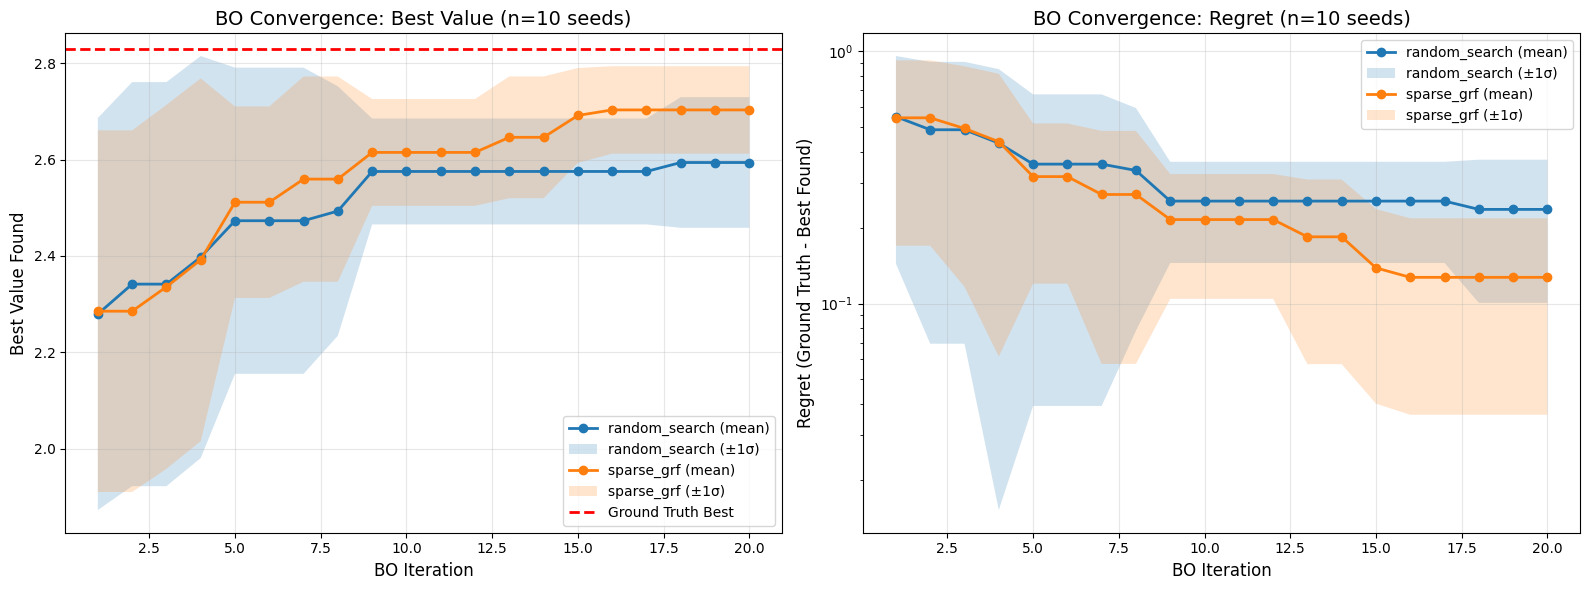


📊 Final Performance Summary:

RANDOM_SEARCH:
  Best Value: 2.5938 ± 0.1355
  Final Regret: 0.2361 ± 0.1355
  Success Rate: 10.0% (regret < 0.1)

SPARSE_GRF:
  Best Value: 2.7029 ± 0.0907
  Final Regret: 0.1270 ± 0.0907
  Success Rate: 30.0% (regret < 0.1)


In [7]:
# Display results summary with statistical analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Best value convergence with mean ± std
for algorithm in bo_results_df['algorithm'].unique():
    algo_data = bo_results_df[bo_results_df['algorithm'] == algorithm]
    
    # Group by iteration and compute statistics across BO seeds
    mean_values = algo_data.groupby('iteration')['best_value'].mean()
    std_values = algo_data.groupby('iteration')['best_value'].std()
    
    # Plot mean line
    ax1.plot(mean_values.index, mean_values.values, marker='o', label=f'{algorithm} (mean)', linewidth=2)
    
    # Add shaded area for ±1 std
    ax1.fill_between(mean_values.index, 
                     mean_values.values - std_values.values,
                     mean_values.values + std_values.values, 
                     alpha=0.2, label=f'{algorithm} (±1σ)')

# Add ground truth line
ax1.axhline(y=bo_results_df['ground_truth_best'].iloc[0], color='red', linestyle='--', 
           label='Ground Truth Best', linewidth=2)

ax1.set_xlabel('BO Iteration', fontsize=12)
ax1.set_ylabel('Best Value Found', fontsize=12)
ax1.set_title(f'BO Convergence: Best Value (n={len(config.BO_SEEDS)} seeds)', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Regret convergence with mean ± std
for algorithm in bo_results_df['algorithm'].unique():
    algo_data = bo_results_df[bo_results_df['algorithm'] == algorithm]
    
    # Group by iteration and compute statistics
    mean_regret = algo_data.groupby('iteration')['regret'].mean()
    std_regret = algo_data.groupby('iteration')['regret'].std()
    
    # Plot mean line  
    ax2.plot(mean_regret.index, mean_regret.values, marker='o', label=f'{algorithm} (mean)', linewidth=2)
    
    # Add shaded area for ±1 std
    ax2.fill_between(mean_regret.index,
                     mean_regret.values - std_regret.values,
                     mean_regret.values + std_regret.values,
                     alpha=0.2, label=f'{algorithm} (±1σ)')

ax2.set_xlabel('BO Iteration', fontsize=12)
ax2.set_ylabel('Regret (Ground Truth - Best Found)', fontsize=12)
ax2.set_title(f'BO Convergence: Regret (n={len(config.BO_SEEDS)} seeds)', fontsize=14)
ax2.set_yscale('log')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final performance statistics
print("\n📊 Final Performance Summary:")
print("=" * 50)

final_iteration = bo_results_df['iteration'].max()
final_results = bo_results_df[bo_results_df['iteration'] == final_iteration]

for algorithm in final_results['algorithm'].unique():
    algo_final = final_results[final_results['algorithm'] == algorithm]
    
    mean_best = algo_final['best_value'].mean()
    std_best = algo_final['best_value'].std()
    mean_regret = algo_final['regret'].mean()
    std_regret = algo_final['regret'].std()
    
    print(f"\n{algorithm.upper()}:")
    print(f"  Best Value: {mean_best:.4f} ± {std_best:.4f}")
    print(f"  Final Regret: {mean_regret:.4f} ± {std_regret:.4f}")
    print(f"  Success Rate: {(algo_final['regret'] < 0.1).mean()*100:.1f}% (regret < 0.1)")

In [8]:
# Save experimental results
def save_bo_results(results_df, config):
    """Save BO results with timestamped files and configuration"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Ensure results directory exists
    os.makedirs(config.RESULTS_DIR, exist_ok=True)
    
    # Get ground truth best value from the results data
    gt_best_value = float(results_df['ground_truth_best'].iloc[0]) if len(results_df) > 0 else None
    
    # Save main results
    main_file = os.path.join(config.RESULTS_DIR, 'bo_experiment_results.csv')
    timestamped_file = os.path.join(config.RESULTS_DIR, f'bo_experiment_results_{timestamp}.csv')
    
    results_df.to_csv(main_file, index=False)
    results_df.to_csv(timestamped_file, index=False)
    
    # Save summary statistics
    summary_stats = results_df.groupby(['algorithm', 'iteration']).agg({
        'best_value': ['mean', 'std', 'min', 'max'],
        'regret': ['mean', 'std', 'min', 'max'],
        'next_value': ['mean', 'std'],
        'dataset_size': ['mean', 'std']
    }).round(6)
    
    summary_file = os.path.join(config.RESULTS_DIR, f'bo_experiment_summary_{timestamp}.csv')
    summary_stats.to_csv(summary_file)
    
    # Save experimental configuration
    config_summary = {
        'timestamp': timestamp,
        'total_experiments': len(results_df),
        'n_nodes': config.N_NODES,
        'noise_std': config.NOISE_STD,
        'walks_per_node': config.WALKS_PER_NODE,
        'p_halt': config.P_HALT,
        'max_walk_length': config.MAX_WALK_LENGTH,
        'learning_rate': config.LEARNING_RATE,
        'train_epochs': config.TRAIN_EPOCHS,
        'num_bo_iterations': config.NUM_BO_ITERATIONS,
        'initial_points': config.INITIAL_POINTS,
        'batch_size': config.BATCH_SIZE,
        'gp_retrain_interval': config.GP_RETRAIN_INTERVAL,
        'num_bo_runs': config.NUM_BO_RUNS,
        'bo_seeds': config.BO_SEEDS,
        'data_seed': config.DATA_SEED,
        'pathwise_samples': config.PATHWISE_SAMPLES,
        'algorithms': sorted(results_df['algorithm'].unique().tolist()),
        'device': str(output_device),
        'ground_truth_best': gt_best_value
    }
    
    config_file = os.path.join(config.RESULTS_DIR, f'bo_experiment_config_{timestamp}.json')
    with open(config_file, 'w') as f:
        json.dump(config_summary, f, indent=2)
    
    # Compute and save final performance metrics
    final_iteration = results_df['iteration'].max()
    final_results = results_df[results_df['iteration'] == final_iteration]
    
    performance_metrics = []
    for algorithm in final_results['algorithm'].unique():
        algo_final = final_results[final_results['algorithm'] == algorithm]
        
        metrics = {
            'algorithm': algorithm,
            'final_best_mean': algo_final['best_value'].mean(),
            'final_best_std': algo_final['best_value'].std(),
            'final_regret_mean': algo_final['regret'].mean(),
            'final_regret_std': algo_final['regret'].std(),
            'success_rate_01': (algo_final['regret'] < 0.1).mean(),
            'success_rate_05': (algo_final['regret'] < 0.5).mean(),
            'num_runs': len(algo_final),
            'convergence_iteration': None,  # Will be computed below
            'ground_truth_best': gt_best_value
        }
        
        # Find convergence iteration (first iteration where mean regret < 0.1)
        algo_data = results_df[results_df['algorithm'] == algorithm]
        mean_regret_by_iter = algo_data.groupby('iteration')['regret'].mean()
        converged_iters = mean_regret_by_iter[mean_regret_by_iter < 0.1]
        if len(converged_iters) > 0:
            metrics['convergence_iteration'] = converged_iters.index[0]
        
        performance_metrics.append(metrics)
    
    performance_df = pd.DataFrame(performance_metrics)
    performance_file = os.path.join(config.RESULTS_DIR, f'bo_experiment_performance_{timestamp}.csv')
    performance_df.to_csv(performance_file, index=False)
    
    print(f"📁 BO Results saved to: {config.RESULTS_DIR}")
    print(f"   Main results: {main_file}")
    print(f"   Timestamped: {timestamped_file}")
    print(f"   Summary: {summary_file}")
    print(f"   Performance: {performance_file}")
    print(f"   Config: {config_file}")
    
    return {
        'main_file': main_file,
        'timestamped_file': timestamped_file,
        'summary_file': summary_file,
        'performance_file': performance_file,
        'config_file': config_file
    }

# Save all results
saved_files = save_bo_results(bo_results_df, config)

# Display final summary
print(f"\n🎉 Bayesian Optimization experiment completed successfully!")
print(f"   Processed {len(bo_results_df)} total experiments")
print(f"   Algorithms: {sorted(bo_results_df['algorithm'].unique())}")
print(f"   BO runs per algorithm: {len(config.BO_SEEDS)}")
print(f"   Graph size: {config.N_NODES} nodes")
print(f"   BO iterations: {config.NUM_BO_ITERATIONS}")
print(f"   Ground truth best: {float(data['Y'][np.argmax(data['Y'])]):.4f}")

📁 BO Results saved to: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/scalable_bo/results
   Main results: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/scalable_bo/results/bo_experiment_results.csv
   Timestamped: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/scalable_bo/results/bo_experiment_results_20250814_174122.csv
   Summary: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/scalable_bo/results/bo_experiment_summary_20250814_174122.csv
   Performance: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/scalable_bo/results/bo_experiment_performance_20250814_174122.csv
   Config: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/scalable_bo/results/bo_experiment_config_20250814_174122.json

🎉 Bayesian Optimization experiment completed successfully!
   Processed 600 total 

/tmp/ipykernel_800578/1766261568.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"   Ground truth best: {float(data['Y'][np.argmax(data['Y'])]):.4f}")
